# Welcome to Computer Vision - Part II

## Setting Up the Workspace

In [1]:
!wget -O data.zip https://www.dropbox.com/s/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip?dl=1
!unzip -o data.zip

--2023-04-23 16:42:29--  https://www.dropbox.com/s/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip [following]
--2023-04-23 16:42:29--  https://www.dropbox.com/s/dl/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0b7adfa69d89f16eae0fdc951b.dl.dropboxusercontent.com/cd/0/get/B6u0--LDRy7e5yRPVTAOZJaprWc8_W3sLiFdGNhNnKSzJQ7QSgpgLiYkuAIt6OClWVGRLj7N5nCWdB7K98vrvZpq6DVHWC4iyffwLr3UAPc-uxL8E4aYTABYaBCOng3CACnzhUHuNTfHwbuiRrNkhlJGesdVjBP0x98cwpK147jG9YZUiwTonh_fJ2ha86FXrL8/file?dl=1# [following]
--2023-04-23 16:42:30--  https://uc0b7adfa6

In [2]:
#Imports
import pandas as pd
import numpy as np
from itertools import product
from skimage import draw, transform

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os, warnings



In [4]:


def circle(size, val=None, r_shrink=0):
    circle = np.zeros([size[0]+1, size[1]+1])
    rr, cc = draw.circle_perimeter(
        size[0]//2, size[1]//2,
        radius=size[0]//2 - r_shrink,
        shape=[size[0]+1, size[1]+1],
    )
    if val is None:
        circle[rr, cc] = np.random.uniform(size=circle.shape)[rr, cc]
    else:
        circle[rr, cc] = val
    circle = transform.resize(circle, size, order=0)
    return circle

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

def show_extraction(image,
                    kernel,
                    conv_stride=1,
                    conv_padding='valid',
                    activation='relu',
                    pool_size=2,
                    pool_stride=2,
                    pool_padding='same',
                    figsize=(10, 10),
                    subplot_shape=(2, 2),
                    ops=['Input', 'Filter', 'Detect', 'Condense'],
                    gamma=1.0):
    # Create Layers
    model = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(
                        filters=1,
                        kernel_size=kernel.shape,
                        strides=conv_stride,
                        padding=conv_padding,
                        use_bias=False,
                        input_shape=image.shape,
                    ),
                    tf.keras.layers.Activation(activation),
                    tf.keras.layers.MaxPool2D(
                        pool_size=pool_size,
                        strides=pool_stride,
                        padding=pool_padding,
                    ),
                   ])

    layer_filter, layer_detect, layer_condense = model.layers
    kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
    layer_filter.set_weights([kernel])

    # Format for TF
    image = tf.expand_dims(image, axis=0)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) 
    
    # Extract Feature
    image_filter = layer_filter(image)
    image_detect = layer_detect(image_filter)
    image_condense = layer_condense(image_detect)
    
    images = {}
    if 'Input' in ops:
        images.update({'Input': (image, 1.0)})
    if 'Filter' in ops:
        images.update({'Filter': (image_filter, 1.0)})
    if 'Detect' in ops:
        images.update({'Detect': (image_detect, gamma)})
    if 'Condense' in ops:
        images.update({'Condense': (image_condense, gamma)})
    
    # Plot
    plt.figure(figsize=figsize)
    for i, title in enumerate(ops):
        image, gamma = images[title]
        plt.subplot(*subplot_shape, i+1)
        plt.imshow(tf.image.adjust_gamma(tf.squeeze(image), gamma))
        plt.axis('off')
        plt.title(title)

---
# 1. The Sliding Window

Last week, we learned about the three operations that carry out feature extraction from an image:
1. *Filter* with a **convolution** layer
2. *Detect* with **ReLU** activation
3. *Condense* with a **maximum pooling** layer

The convolution and pooling operations share a common feature: they are both performed over a **sliding window**. With convolution, this "window" is given by the dimensions of the kernel, the parameter `kernel_size`. With pooling, it is the pooling window, given by `pool_size`.

<figure>
<img src="https://i.imgur.com/LueNK6b.gif" width=400 alt="A 2D sliding window.">
</figure>

There are two additional parameters affecting both convolution and pooling layers -- these are the `strides` of the window and whether to use `padding` at the image edges. The `strides` parameter says how far the window should move at each step, and the `padding` parameter describes how we handle the pixels at the edges of the input.

With these two parameters, defining the two layers becomes:

In [ ]:
#from tensorflow import keras
#from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  activation='relu'),
    layers.MaxPool2D(pool_size=2,
                     strides=1,
                     padding='same')
    # More layers follow
])

## Stride

The distance the window moves at each step is called the **stride**. We need to specify the stride in both dimensions of the image: one for moving left to right and one for moving top to bottom. This animation shows `strides=(2, 2)`, a movement of 2 pixels each step.

<figure>
<img src="https://i.imgur.com/Tlptsvt.gif" width=400 alt="Sliding window with a stride of (2, 2).">
</figure>

What effect does the stride have? Whenever the stride in either direction is greater than 1, the sliding window will skip over some of the pixels in the input at each step.

Because we want high-quality features to use for classification, convolutional layers will most often have `strides=(1, 1)`. Increasing the stride means that we miss out on potentially valuble information in our summary. Maximum pooling layers, however, will almost always have stride values greater than 1, like `(2, 2)` or `(3, 3)`, but not larger than the window itself.

Finally, note that when the value of the `strides` is the same number in both directions, you only need to set that number; for instance, instead of `strides=(2, 2)`, you could use `strides=2` for the parameter setting.


## Padding 

When performing the sliding window computation, there is a question as to what to do at the boundaries of the input. Staying entirely inside the input image means the window will never sit squarely over these boundary pixels like it does for every other pixel in the input. Since we aren't treating all the pixels exactly the same, could there be a problem?

What the convolution does with these boundary values is determined by its `padding` parameter. In TensorFlow, you have two choices: either `padding='same'` or `padding='valid'`. There are trade-offs with each.

When we set `padding='valid'`, the convolution window will stay entirely inside the input. The drawback is that the output shrinks (loses pixels), and shrinks more for larger kernels. This will limit the number of layers the network can contain, especially when inputs are small in size.

The alternative is to use `padding='same'`. The trick here is to **pad** the input with 0's around its borders, using just enough 0's to make the size of the output the *same* as the size of the input. This can have the effect however of diluting the influence of pixels at the borders. The animation below shows a sliding window with `'same'` padding.

<figure>
<img src="https://i.imgur.com/RvGM2xb.gif" width=400 alt="Illustration of zero (same) padding.">
</figure>

The VGG model we've been looking at uses `same` padding for all of its convolutional layers. Most modern convnets will use some combination of the two. (Another parameter to tune!)



## Example - Exploring Sliding Windows

To better understand the effect of the sliding window parameters, it can help to observe a feature extraction on a low-resolution image so that we can see the individual pixels. Let's just look at a simple circle.

This next cell will create an image and kernel for us.

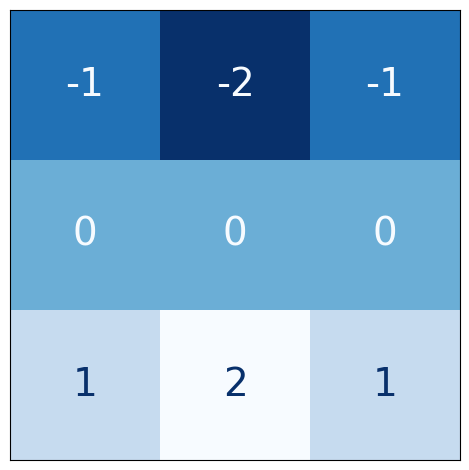

In [5]:

#import tensorflow as tf
#import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image = circle([64, 64], val=1.0, r_shrink=3)
image = tf.reshape(image, [*image.shape, 1])
# Bottom sobel
kernel = tf.constant(
    [[-1, -2, -1],
     [0, 0, 0],
     [1, 2, 1]],
)

show_kernel(kernel)

The VGG architecture is fairly simple. It uses convolution with strides of 1 and maximum pooling with $2 \times 2$ windows and strides of 2. We've included a function in the `visiontools` utility script that will show us all the steps.

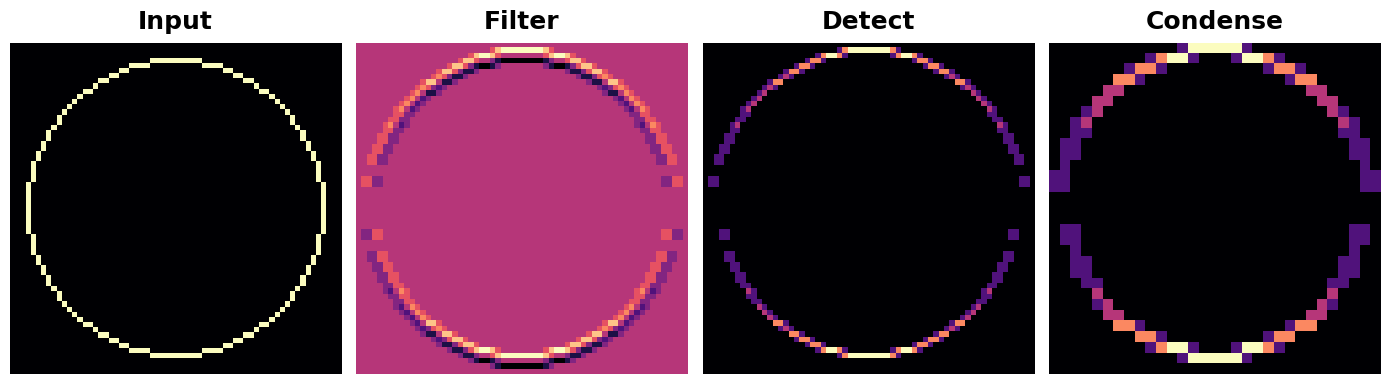

In [6]:
show_extraction(
    image, kernel,

    # Window parameters
    conv_stride=1,
    pool_size=2,
    pool_stride=2,

    subplot_shape=(1, 4),
    figsize=(14, 6),
)

And that works pretty well! The kernel was designed to detect horizontal lines, and we can see that in the resulting feature map the more horizontal parts of the input end up with the greatest activation.

What would happen if we changed the strides of the convolution to 3?

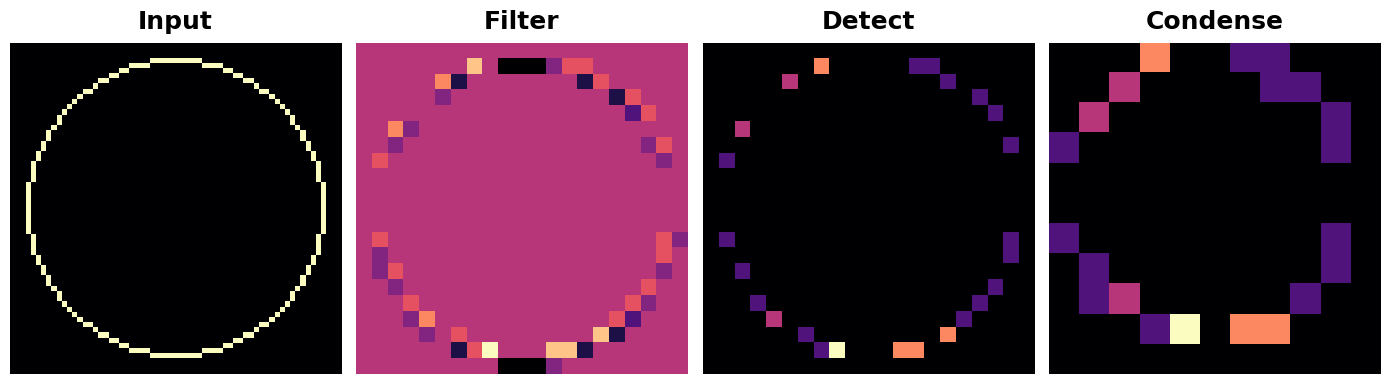

In [7]:
show_extraction(
    image, kernel,

    # Window parameters
    conv_stride=3,
    pool_size=2,
    pool_stride=2,

    subplot_shape=(1, 4),
    figsize=(14, 6),    
)

This seems to reduce the quality of the feature extracted. Our input circle is rather "finely detailed," being only 1 pixel wide. A convolution with strides of 3 is too coarse to produce a good feature map from it.

Sometimes, a model will use a convolution with a larger stride in it's initial layer. This will usually be coupled with a larger kernel as well. The ResNet50 model, for instance, uses $7 \times 7$ kernels with strides of 2 in its first layer. This seems to accelerate the production of large-scale features without the sacrifice of too much information from the input.

### Take-Away

We looked at a characteristic computation common to both convolution and pooling: the **sliding window** and the parameters affecting its behavior in these layers. This style of windowed computation contributes much of what is characteristic of convolutional networks and is an essential part of their functioning.



## In Lab: *Explore Sliding Windows*

In lab, you'll explore sliding windows and learn about how *stacking* convolutional layers can increase the effective window size.

---
# 2. Custom Convnets

Now that you've seen the layers a convnet uses to extract features, it's time to put them together and build a network of your own!

## Simple to Refined 

In the last class, we saw how convolutional networks perform **feature extraction** through three operations: **filter**, **detect**, and **condense**. A single round of feature extraction can only extract relatively simple features from an image, things like simple lines or contrasts. These are too simple to solve most classification problems. Instead, convnets will repeat this extraction over and over, so that the features become more complex and refined as they travel deeper into the network.

<figure>
<img src="https://i.ibb.co/jvSm5fn/feature-extraction.png" alt="Features extracted from an image of a box, from simple to refined." width=800>
</figure>

## Convolutional Blocks

It does this by passing them through long chains of **convolutional blocks** which perform this extraction.

<figure>
<img src="https://i.imgur.com/pr8VwCZ.png" width="400" alt="Extraction as a sequence of blocks.">
</figure>

These convolutional blocks are stacks of `Conv2D` and `MaxPool2D` layers, whose role in feature extraction we learned about in the last class.

<figure>
<!-- <img src="./images/2-block-crp.png" width="400" alt="A kind of extraction block: convolution, ReLU, pooling."> -->
<img src="https://i.imgur.com/8D6IhEw.png" width="400" alt="A kind of extraction block: convolution, ReLU, pooling.">
</figure>

Each block represents a round of extraction, and by composing these blocks the convnet can combine and recombine the features produced, growing them and shaping them to better fit the problem at hand. The deep structure of modern convnets is what allows this sophisticated feature engineering and has been largely responsible for their superior performance.




## Example - Design a Convnet #

Let's see how to define a deep convolutional network capable of engineering complex features. In this example, we'll create a Keras `Sequence` model and then train it on our dataset.


### Step 1 - Load Data 

This cell loads the data.

In [8]:
#import os, warnings
#import matplotlib.pyplot as plt
#from matplotlib import gridspec

#import numpy as np
#import tensorflow as tf
#from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    tf.keras.utils.set_random_seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [9]:
# Define the input function
def read_tf_records(tfrecord_path, batch_size):
    # Create a TFRecordDataset object
    dataset = tf.data.TFRecordDataset(tfrecord_path)

    # Define the feature description
    feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
    }


    # Parse the record into tensors
    def _parse_function(example_proto):
        return tf.io.parse_single_example(example_proto, feature_description)

    # Apply the parse function to every record
    dataset = dataset.map(_parse_function)
    # Decode the image
    def decode_image(record):
        image = tf.image.decode_jpeg(record['image/encoded'], channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, (224, 224))
        image = tf.reshape(image, [-1, 224, 224, 3])
        label = tf.sparse.to_dense(record['image/object/class/label'])
        #Convert label into binary classification whether the box has a label
        label = tf.maximum(0, tf.reduce_max(tf.cast(tf.math.equal(label, 1), tf.int32)))
        label = tf.reshape(label, (-1,1))
        return image, label

    # Apply the decode_image function to every record
    dataset = dataset.map(decode_image)

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    # Return the dataset
    return dataset

ds_train = read_tf_records('train/Package-and-label.tfrecord',128)

ds_valid = read_tf_records('valid/Package-and-label.tfrecord',128)

ds_test = read_tf_records('test/Package-and-label.tfrecord',128)

### Step 2 - Define Model 

Here is a diagram of the model we'll use:

<figure>
<img src="https://i.ibb.co/TKS0K5Q/cnn-architecture.png" width="250" alt="Diagram of a convolutional model."> 
</figure>

Now we'll define the model. See how our model consists of three blocks of `Conv2D` and `MaxPool2D` layers (the base) followed by a head of `Dense` layers. We can translate this diagram more or less directly into a Keras `Sequential` model just by filling in the appropriate parameters.

In [11]:
#from tensorflow import keras
#from tensorflow.keras import layers

model = keras.Sequential([

    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[224, 224, 3]),
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=64, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 128)     

Notice in this definition is how the number of filters doubled block-by-block: 32, 64, 128. This is a common pattern. Since the `MaxPool2D` layer is reducing the *size* of the feature maps, we can afford to increase the *quantity* we create.

### Step 3 - Train 

We can train this model just like the model from section 1: compile it with an optimizer along with a loss and metric appropriate for binary classification.

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=40,
    verbose=1,
)


Epoch 1/40
1635/1635 [==============================] - 18s 6ms/step - loss: 0.6810 - binary_accuracy: 0.5798 - val_loss: 0.6362 - val_binary_accuracy: 0.5563
Epoch 2/40
1635/1635 [==============================] - 8s 5ms/step - loss: 0.6552 - binary_accuracy: 0.6324 - val_loss: 0.6860 - val_binary_accuracy: 0.5430
Epoch 3/40
1635/1635 [==============================] - 9s 5ms/step - loss: 0.6300 - binary_accuracy: 0.6532 - val_loss: 0.6525 - val_binary_accuracy: 0.6358
Epoch 4/40
1635/1635 [==============================] - 8s 5ms/step - loss: 0.5790 - binary_accuracy: 0.6985 - val_loss: 0.5946 - val_binary_accuracy: 0.7020
Epoch 5/40
1635/1635 [==============================] - 8s 5ms/step - loss: 0.5143 - binary_accuracy: 0.7401 - val_loss: 0.5834 - val_binary_accuracy: 0.6887
Epoch 6/40
1635/1635 [==============================] - 8s 5ms/step - loss: 0.4196 - binary_accuracy: 0.7951 - val_loss: 0.6563 - val_binary_accuracy: 0.6225
Epoch 7/40
1635/1635 [=============================

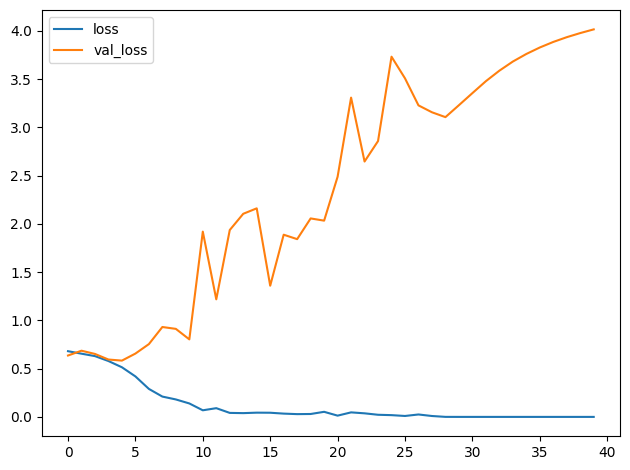

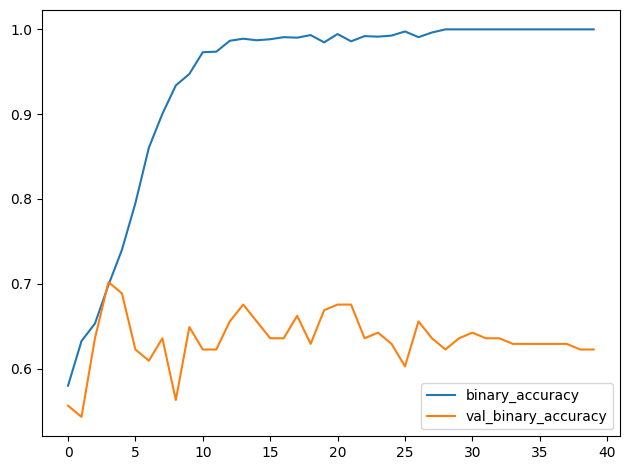

In [14]:
#import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

This model is much smaller than the VGG16 model from last class -- only 3 convolutional layers versus the 16 of VGG16. It was nevertheless able to fit this dataset fairly well. We might still be able to improve this simple model by adding more convolutional layers, hoping to create features better adapted to the dataset. This is what we'll try in the exercises.

### Take-Away

You saw how to build a custom convnet composed of many **convolutional blocks** and capable of complex feature engineering. 

## In Lab: *Create a Custom Convnet*

In the exercises, you'll create a convnet that performs as well on this problem as VGG16 does -- without pretraining! 

---
# 3. Data Augmentation

Now that you've learned the fundamentals of convolutional classifiers, you're ready to move on to more advanced topics.

In this lesson, you'll learn a trick that can give a boost to your image classifiers: it's called **data augmentation**. 


## The Usefulness of Fake Data 

The best way to improve the performance of a machine learning model is to train it on more data. The more examples the model has to learn from, the better it will be able to recognize which differences in images matter and which do not. More data helps the model to *generalize* better.

One easy way of getting more data is to use the data you already have. If we can transform the images in our dataset in ways that preserve the class, we can teach our classifier to ignore those kinds of transformations. For instance, whether a package is tilted left or right in a photo doesn't change the fact that it has a label or not. So, if we **augment** our training data with tilted images, our classifier will learn that "left or right" is a difference it should ignore.

And that's the whole idea behind data augmentation: add in some extra fake data that looks reasonably like the real data and your classifier will improve.

### Examples of Original Images (already augmented)

In [15]:
x = np.concatenate([x for x, y in ds_train], axis=0)
y = np.concatenate([y for x, y in ds_train], axis=0)

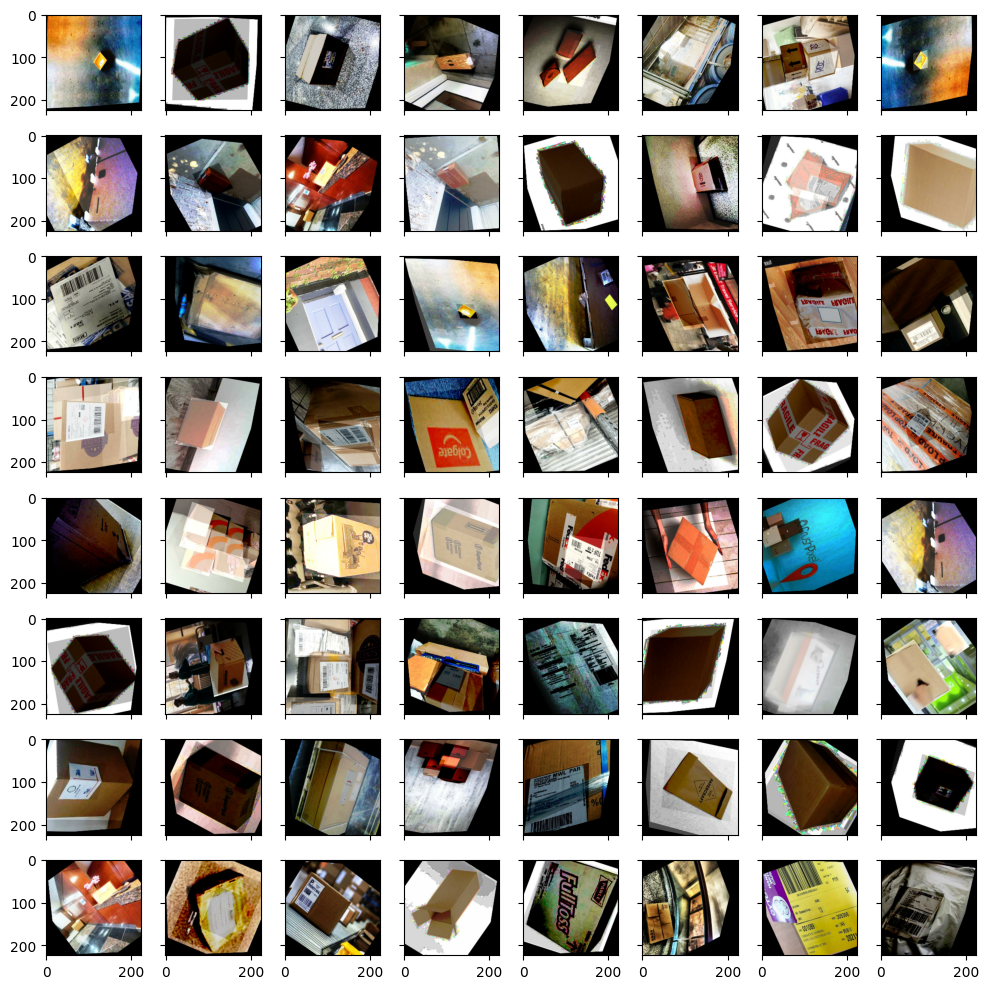

In [16]:
height = 8
width = 8

for i in range(height*width):
    # create a grid of images
    fig, ax = plt.subplots(height, width, sharex=True, sharey=True, figsize=(10,10))
    for i in range(width):
        for j in range(height):
            ax[i][j].imshow(x[i*width+j], cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

## Using Data Augmentation

Typically, many kinds of transformation are used when augmenting a dataset. These might include rotating the image, adjusting the color or contrast, warping the image, or many other things, usually applied in combination. 

Data augmentation is usually done *online*, meaning, as the images are being fed into the network for training. Recall that training is usually done on mini-batches of data. This is what the above batch of images might look like when additional data augmentation is used.

### Examples of Additional Augmented Images

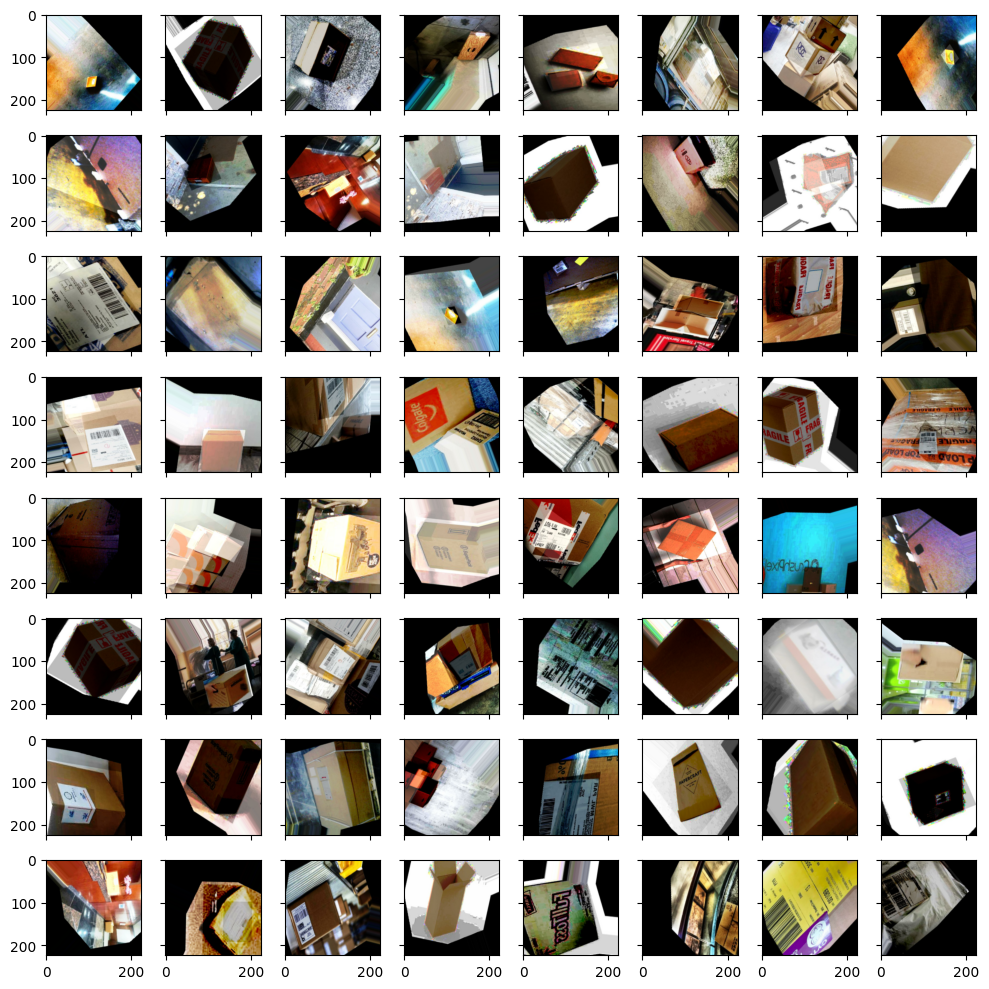

In [17]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True, 
                                                          featurewise_std_normalization=True,
                                                          zoom_range=0.2,
                                                          horizontal_flip=True,
                                                          vertical_flip=True,
                                                          rotation_range=150,
                                                          width_shift_range=0.2,
                                                          height_shift_range=0.2)

for X_batch, y_batch in datagen.flow(x, y, batch_size=height*width, shuffle=False):
    # create a grid of images
    fig, ax = plt.subplots(height, width, sharex=True, sharey=True, figsize=(10,10))
    for i in range(width):
        for j in range(height):
            ax[i][j].imshow(X_batch[i*width+j], cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break


Each time an image is used during training, a new random transformation is applied. This way, the model is always seeing something a little different than what it's seen before. This extra variance in the training data is what helps the model on new data.

It's important to remember though that not every transformation will be useful on a given problem. Most importantly, whatever transformations you use should not mix up the classes. If you were training a digit recognizer, for instance, rotating images would mix up '9's and '6's. In the end, the best approach for finding good augmentations is the same as with most ML problems: try it and see!

## Example - Training with Data Augmentation #

Keras lets you augment your data in two ways. The first way is to include it in the data pipeline with a function like [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). The second way is to include it in the model definition by using Keras's **preprocessing layers**. This is the approach that we'll take. The primary advantage for us is that the image transformations will be computed on the GPU instead of the CPU, potentially speeding up training.

In this example, we'll learn how to improve the classifier through data augmentation. 

### Step 1 - Load Data 

We already loaded the data above.

### Step 2 - Define Model

To illustrate the effect of augmentation, we'll just add a couple of simple transformations to the model from last class with the pre-trained base.

In [18]:
#from tensorflow import keras
#from tensorflow.keras import layers


pretrained_base = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
pretrained_base.trainable = False

model = keras.Sequential([
    # Preprocessing
    layers.RandomFlip('horizontal'), # flip left-to-right
    layers.RandomContrast(0.5), # contrast change by up to 50%
    # Base
    pretrained_base,
    # Head
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

58889256/58889256 [==============================] - 0s 0us/step


### Step 3 - Train and Evaluate

And now we'll start the training!

In [19]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=1,
)

Epoch 1/30
1635/1635 [==============================] - 22s 11ms/step - loss: 0.6499 - binary_accuracy: 0.7346 - val_loss: 0.4466 - val_binary_accuracy: 0.7748
Epoch 2/30
1635/1635 [==============================] - 18s 11ms/step - loss: 0.3995 - binary_accuracy: 0.8220 - val_loss: 0.4829 - val_binary_accuracy: 0.7616
Epoch 3/30
1635/1635 [==============================] - 22s 14ms/step - loss: 0.3338 - binary_accuracy: 0.8593 - val_loss: 0.4980 - val_binary_accuracy: 0.7483
Epoch 4/30
1635/1635 [==============================] - 20s 12ms/step - loss: 0.2649 - binary_accuracy: 0.8917 - val_loss: 0.4904 - val_binary_accuracy: 0.8278
Epoch 5/30
1635/1635 [==============================] - 19s 11ms/step - loss: 0.2290 - binary_accuracy: 0.9107 - val_loss: 0.5160 - val_binary_accuracy: 0.7947
Epoch 6/30
1635/1635 [==============================] - 19s 11ms/step - loss: 0.1980 - binary_accuracy: 0.9107 - val_loss: 0.6397 - val_binary_accuracy: 0.7947
Epoch 7/30
1635/1635 [==================

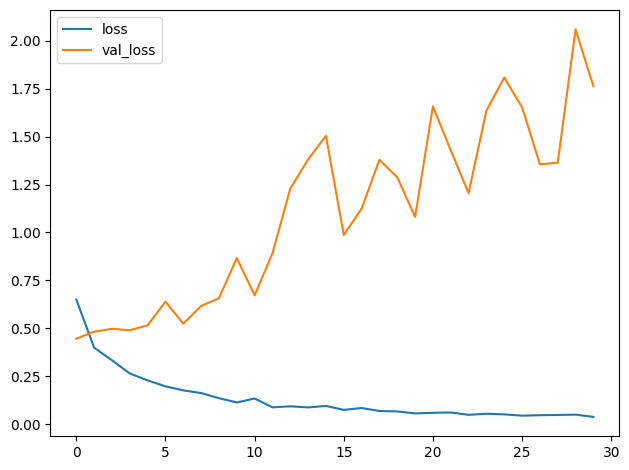

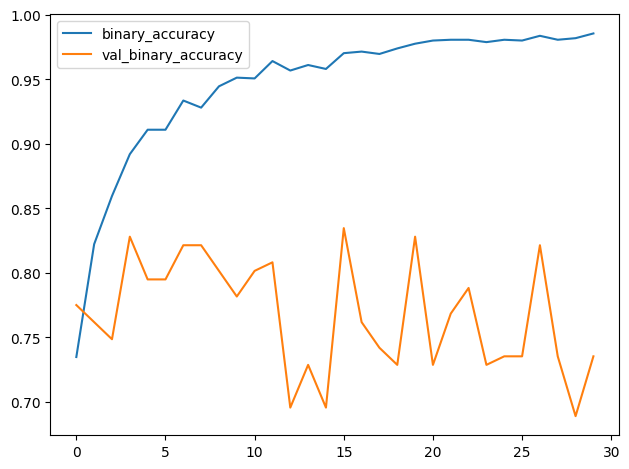

In [20]:
#import pandas as pd

history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

<figure>
<img src="https://i.ibb.co/zVHjZ83/output-Loss.png" width="500" alt="Diagram of a convolutional model."> 
</figure>

<figure>
<img src="https://i.ibb.co/4NnzbxV/output-Accuracy.png" width="500" alt="Diagram of a convolutional model."> 
</figure>

The training and validation curves in the model from section 1 diverged fairly quickly, suggesting that it could benefit from some regularization. The learning curves for this model were able to stay closer together, and we achieved some modest improvement in validation loss and accuracy. This suggests that the dataset did indeed benefit from the augmentation.

## In Lab: *Apply Data Augmentation*

In Lab, you will apply data augmentation to the custom convnet you built above. This will be your best model ever!